<a href="https://colab.research.google.com/github/neurologic/Neurophysiology-Lab/blob/main/modules/crayfish-erg/Data-Explorer_crayfish-erg.ipynb" target="_blank" rel="noopener noreferrer"><img alt="Open In Colab" src="https://colab.research.google.com/assets/colab-badge.svg"/></a>   

# Data Explorer

<a id="toc"></a>
# Table of Contents

- [Introduction](#intro)
- [Setup](#setup)
- [Analysis tool 1](#one)
- [Analysis tool 1](#two)


<a id="setup"></a>
# Setup

[toc](#toc)

Import and define functions

In [1]:
#@title {display-mode: "form"}

#@markdown Run this code cell to import packages and define functions 
from pathlib import Path
import random
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy import ndimage, optimize, signal
from scipy.optimize import curve_fit
from scipy.signal import hilbert,medfilt,resample, find_peaks,butter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from datetime import datetime,timezone,timedelta
pal = sns.color_palette(n_colors=15)
pal = pal.as_hex()
from numpy import NaN

from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
from ipywidgets import widgets, interact, interactive,interactive_output
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/master/nma.mplstyle")

def monoExp(x, m, t, b):
    return m * np.exp(-x / t) + b


print('Task completed at ' + str(datetime.now(timezone(-timedelta(hours=5)))))

Task completed at 2022-11-06 09:24:02.684026-05:00


Mount Google Drive

In [ ]:
#@title {display-mode: "form"}

#@markdown Run this cell to mount your Google Drive.

from google.colab import drive
drive.mount('/content/drive')

print('Task completed at ' + str(datetime.now(timezone(-timedelta(hours=5)))))

<a id="one"></a>

# Analysis tool 1: adaptation rate

Use this analysis tool for experiment files from steps \#2-4 in the Lab Manual. 
> If you would like to explore the analysis for this lab, but do not have data, you can download examples for the following experiments using the linked shared files: 

First, you will tweak the parameters of the analysis so that the peak ERG amplitude on each trial is automatically be calculated for the entire file at once. 
  > One of the parameters you need for this processing step ("time to peak (s)") comes from using the Dash Data Explorer to determine the rise time of the ERG to a 10msec pulse. 

Then, you will programatically (ie. automativally) write the processing results to a csv file for each stimulus rate. 

Finally, you will programatically load all of the csv files to create an overlaid scatter plot of the results across stimulus rate conditions.



## 1. Import raw data and measure ERG amplitude

Raw data should be in a format digitized with *Nidaq USB6211* and recorded using *Bonsai-rx* as a *.bin* file

In [15]:
#@title {display-mode: "form"}


#@markdown Specify the file path 
#@markdown to your recorded data in the colab runtime (find the filepath in the colab file manager):

filepath = "full filepath goes here"  #@param 
filepath = '/Volumes/Untitled/BIOL247/data/crayfish-erg/KP_20221104/rate-10hz_0.bin'

#@markdown Specify the sampling rate and number of channels recorded.

sampling_rate = None #@param
number_channels = None #@param

sampling_rate = 30000 #@param
number_channels = 2 #@param

# downsample = False #@param
# newfs = 10000 #@param

#@markdown After you have filled out all form fields, 
#@markdown run this code cell to load the data. 

filepath = Path(filepath)

# No need to edit below this line
#################################
data = np.fromfile(Path(filepath), dtype = np.float64)
data = data.reshape(-1,number_channels)
data_dur = np.shape(data)[0]/sampling_rate
print('duration of recording was %0.2f seconds' %data_dur)

fs = sampling_rate
# if downsample:
#     # newfs = 10000 #downsample emg data
#     chunksize = int(sampling_rate/newfs)
#     data = data[0::chunksize,:]
#     fs = int(np.shape(data)[0]/data_dur)

time = np.linspace(0,data_dur,np.shape(data)[0])

print('Data upload completed at ' + str(datetime.now(timezone(-timedelta(hours=5)))))

#@markdown Run this cell to create an interactive plot with a slider to scroll 
#@markdown through the signal
#@markdown and set an appropriate event detection threshold and noise threshold. 

slider_xrange = widgets.FloatRangeSlider(
    min=0,
    max=data_dur,
    value=(0,data_dur),
    step= 0.5,
    readout=True,
    continuous_update=False,
    description='Time Range (s)',
    style = {'description_width': '200px'})
slider_xrange.layout.width = '600px'

slider_yrange = widgets.FloatRangeSlider(
    min=-5,
    max=5,
    value=[-2,1],
    step=0.05,
    continuous_update=False,
    readout=True,
    description='yrange',
    style = {'description_width': '200px'})
slider_yrange.layout.width = '600px'

slider_text = widgets.Text(
    value='0.04',
    placeholder='0.04',
    description='time to peak (s)',
    style = {'description_width': '200px'},
    disabled=False
)
select_channel = widgets.Select(
    options=np.arange(np.shape(data)[1]), # start with a single trial on a single bout... it will update when runs ; old: np.arange(len(trial_times)),
    value=0,
    #rows=10,
    description='Channel',
    style = {'description_width': '50px'},
    disabled=False
)
select_channel.layout.width = '100px'
select_channel.layout.height = '50px'

# slider_threshold = widgets.FloatSlider(
#     min=0,
#     max=5,
#     value=0.2,
#     step=0.005,
#     readout_format='.3f',
#     continuous_update=False,
#     readout=True,
#     description='event detection threshold',
#     style = {'description_width': '200px'})
# slider_threshold.layout.width = '600px'

radio_polarity = widgets.RadioButtons(
    options=[1, -1],
    value=-1,
    description='peaks polarity',
    layout={'width': 'max-content'},
    style = {'description_width': '100px'},
    disabled=False
)

ui_peaks = widgets.HBox([select_channel, radio_polarity, slider_threshold])

# detect_type_radio = widgets.RadioButtons(
#     options=['peak', 'level crossing positive', 'level crossing negative'],
#     value='level crossing positive', # Defaults to 'level crossing'
#     layout={'width': 'max-content'}, # If the items' names are long
#     description='Type of event detection',
#     style = {'description_width': '200px'},
#     disabled=False
# )

iei_text = widgets.Text(
    value='0.00005',
    placeholder='0.0001',
    description='min IEI (seconds)',
    style = {'description_width': '200px'},
    disabled=False
)

noise_amp_text = widgets.Text(
    value='0.06',
    placeholder='0.06',
    description='peak-to-peak noise amp',
    style = {'description_width': '200px'},
    disabled=False
)

def update_plot(chan_,xrange,yrange,polarity,iei,noise_amp,onset):
    fig, ax = plt.subplots(figsize=(10,5),num=1); #specify figure number so that it does not keep creating new ones
    
    signal = data[:,chan_].reshape(-1)
    # signal = signal-np.median(signal)

    
    iei = float(iei)
    noise_amp = float(noise_amp)
    onset = float(onset)
    prepeak_base = int(onset*fs)
    
    if iei>1/fs:
        d = iei*fs #minimum time allowed between distinct events

        # if thresh_ >=0:
        #     r = find_peaks(signal,height=thresh_,distance=d)
        # if thresh_ <0:
        #     r = find_peaks(-1*signal,height=-1*thresh_,distance=d)
        # trial_times = r[0]/fs

        if polarity == 1:
            # r_thresh = find_peaks(signal,height=thresh_,distance=d)
            r_prom = find_peaks(signal,distance=d,prominence=noise_amp)
            r_ind = r_prom[0] #np.intersect1d(r_thresh[0],r_prom[0])
            # lagging_peak_amp = r[1]['peak_heights']
            peak_amp = signal[r_ind]
            base_amp = signal[r_ind-prepeak_base]
            # ax.hlines(thresh_, xrange[0],xrange[1],linestyle='--',color='green')
        if polarity == -1:
            # r = find_peaks(-1*lagging_signal,height=-1*thresh_,distance=d,prominence=float(noise_amp))
            r_thresh = find_peaks(-1*signal,height=thresh_,distance=d)
            r_prom = find_peaks(-1*signal,distance=d,prominence=noise_amp)
            r_ind = r_prom[0] #np.intersect1d(r_thresh[0],r_prom[0])
            # lagging_peak_amp = -1*r[1]['peak_heights']
            peak_amp = signal[r_ind]
            base_amp = signal[r_ind-prepeak_base]
            # ax.hlines(-thresh_, xrange[0],xrange[1],linestyle='--',color='green')

        peak_times = np.asarray([np.round(s/fs,2) for s in r_ind])

        starti = int(xrange[0]*fs)+1
        stopi = int(xrange[1]*fs)-1
        ax.plot(time[starti:stopi], signal[starti:stopi], color='black')


        inwin_inds = (peak_times>(xrange[0])) & (peak_times<(xrange[1]))
        ax.scatter(peak_times[inwin_inds],peak_amp[inwin_inds], zorder=3,color='red',s=20)
        ax.scatter(peak_times[inwin_inds]-onset,base_amp[inwin_inds], zorder=3,color='green',s=20)

        ax.set_ylim(yrange[0],yrange[1])
        ax.set_xlim(xrange[0],xrange[1])

        ax.xaxis.set_minor_locator(AutoMinorLocator(5))


        return peak_times, peak_amp-base_amp

# w_trials_ = interactive(update_plot, chan_=select_channel, 
#                         xrange=slider_xrange, 
#                         thresh_=slider_threshold, iei = iei_text, noise_amp = noise_amp_text);
# display(w_trials_)
w_peak_detect_all = interactive(update_plot, chan_=select_channel, 
                        yrange=slider_yrange,xrange=slider_xrange,
                                polarity = radio_polarity, iei = iei_text,noise_amp=noise_amp_text,
                               onset=slider_text);
display(w_peak_detect_all)

# w_peak_detect_all = interactive(update_plot, {'chan_':select_channel,
#                                      'yrange':slider_yrange, 
#                                      'xrange':slider_xrange,
#                                      'thresh_':slider_threshold,
#                                      'polarity':radio_polarity,
#                                      'iei':iei_text,
#                                      'noise_amp':noise_amp_text});
# display(ui_peaks,widgets.HBox([iei_text,noise_amp_text]),w_peak_detect_all,ui_range)

duration of recording was 14.67 seconds
Data upload completed at 2022-11-06 10:04:32.124860-05:00


interactive(children=(Select(description='Channel', layout=Layout(height='50px', width='100px'), options=(0, 1…

## 2. Save processed data as .csv

Specify the stimulus rate for the data you just processed. The rate should be a string (ie. surrounded by quotes).
> It will take a minute or so to process and actually save, but the .csv file will be saved to the local "content" folder of Google Collaboratory. You can download them individually to your own computer (or move them to your Google Drive) to use again later without re-processing the data. 

In [16]:
#@title {display-mode: "form"}

rate = 'None' #@param

peak_times,peak_amp = w_peak_detect_all.result

df = pd.DataFrame({'time':peak_times,'amp':-peak_amp,'number':np.arange(0,len(peak_amp),1),'rate':rate})

df.to_csv('adaptation_' + rate + '.csv')

## 3. Compare across conditions 

Provide a list of the csv files generated in the last step. The code will iterate through each data file and plot the results. You will also see the result of a mono-exponential fit to the data.

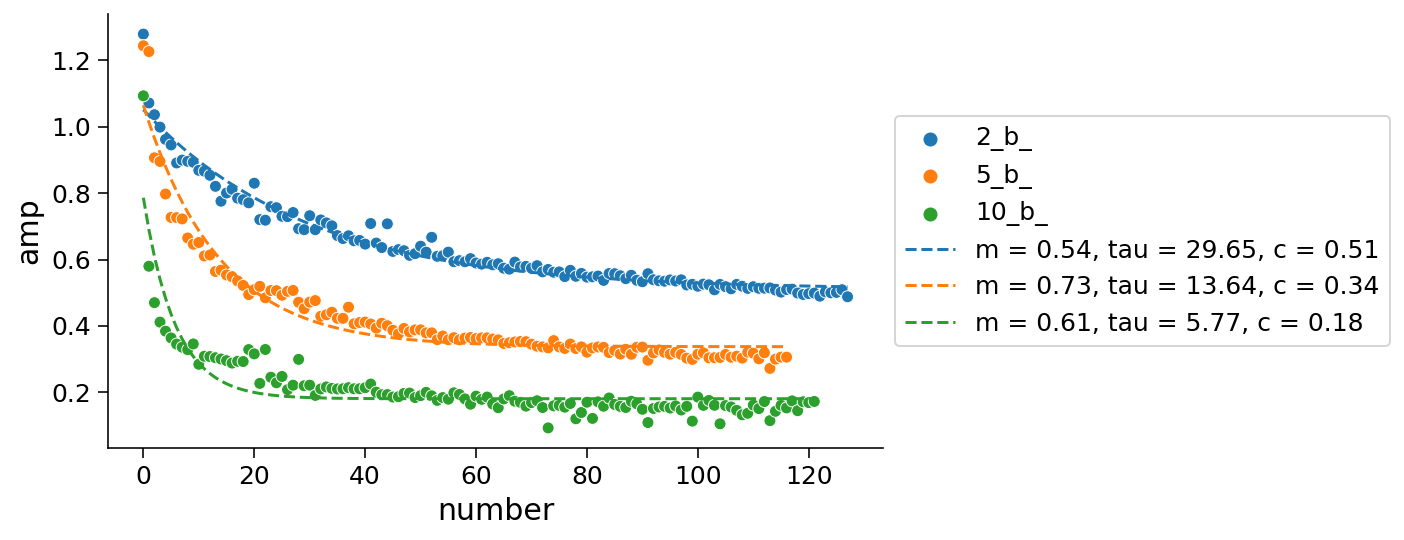

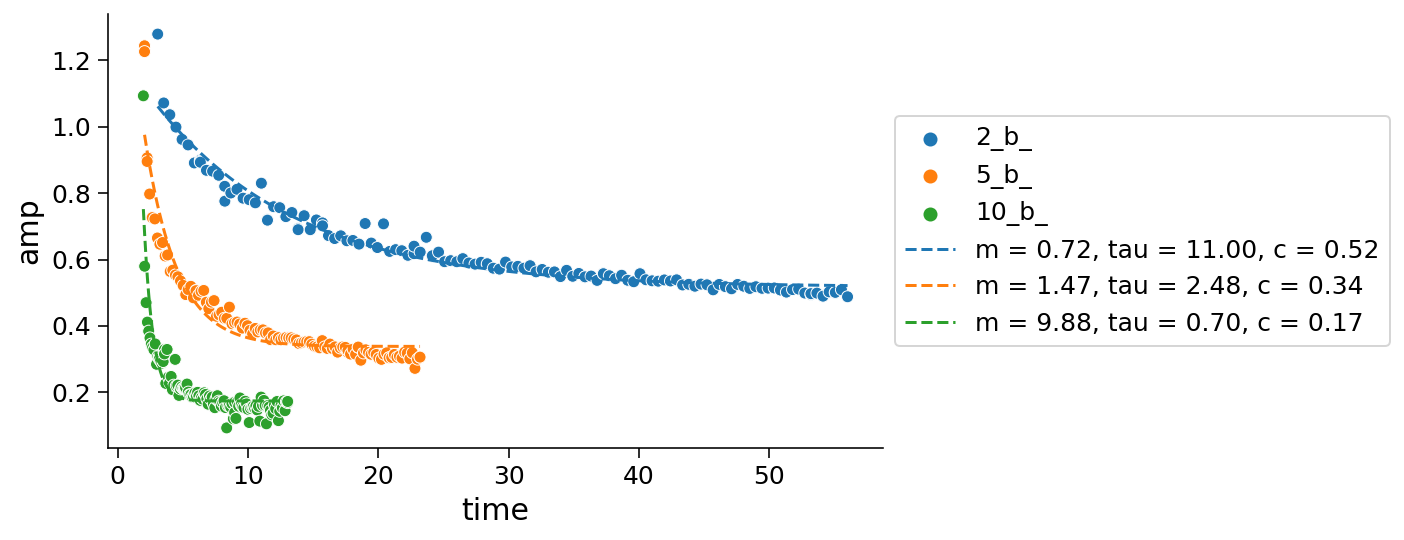

In [18]:
#@title {display-mode: "form"}

#@markdown list the full path to each csv file created using the "adaptation analysis tool."
file_list = ['file1_.csv','file1_.csv','file1_.csv'] #@param

df = pd.DataFrame({})
for f in file_list:
    df_ = pd.read_csv(f)
    df = pd.concat([df,df_])

hfig,ax = plt.subplots(figsize=(10,4))
g=sns.scatterplot(x='number',y='amp',data=df, hue='rate');
for rate in df['rate'].unique():
    xs = df[df['rate']==rate]['number']
    ys = df[df['rate']==rate]['amp']
    # p0 = [10, 2, np.min(ys)] # start with values near those we expect
    params_, cv = curve_fit(monoExp, xs, ys,maxfev = 5000) #monoexponential
    m, t, c = params_
    y_fit = monoExp(xs, m, t, c)#+np.min(ys)

    # ax.scatter(xs,-ys)
    plt.plot(xs,y_fit,label=f'm = {m:.2f}, tau = {t:.2f}, c = {c:.2f}',linestyle='--')
    plt.legend()
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1);

hfig,ax = plt.subplots(figsize=(10,4))
g=sns.scatterplot(x='time',y='amp',data=df, hue='rate');
for rate in df['rate'].unique():
    xs = df[df['rate']==rate]['time']
    ys = df[df['rate']==rate]['amp']
    # p0 = [10, 2, np.min(ys)] # start with values near those we expect
    params_, cv = curve_fit(monoExp, xs, ys,maxfev = 5000) #monoexponential
    m, t, c = params_
    y_fit = monoExp(xs, m, t, c)#+np.min(ys)

    # ax.scatter(xs,-ys)
    plt.plot(xs,y_fit,label=f'm = {m:.2f}, tau = {t:.2f}, c = {c:.2f}',linestyle='--')
    plt.legend()
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1);

# Analysis tool 2: Individual trial analysis

Use this analysis tool for experiment files from steps \#5 and 6 in the Lab Manual.

<a id="two"></a>

## 1. Import data 

Import data digitized with *Nidaq USB6211* and recorded using *Bonsai-rx* as a *.bin* file

> If you would like to explore the analysis for this lab, but do not have data, you can download examples for the following experiments using the linked shared files:  

In [19]:
#@title {display-mode: "form" }

#@markdown Specify the file path 
#@markdown to your recorded data in the colab runtime (find the filepath in the colab file manager):

filepath = "full filepath goes here"  #@param 
filepath = '/Volumes/Untitled/BIOL247/data/crayfish-erg/KP_20221104/duration_0.bin'

#@markdown Specify the sampling rate and number of channels recorded.

sampling_rate = None #@param
number_channels = None #@param

sampling_rate = 30000 #@param
number_channels = 2 #@param

# downsample = False #@param
# newfs = 10000 #@param

#@markdown After you have filled out all form fields, 
#@markdown run this code cell to load the data. 

filepath = Path(filepath)

# No need to edit below this line
#################################
data = np.fromfile(Path(filepath), dtype = np.float64)
data = data.reshape(-1,number_channels)
data_dur = np.shape(data)[0]/sampling_rate
print('duration of recording was %0.2f seconds' %data_dur)

fs = sampling_rate
# if downsample:
#     # newfs = 10000 #downsample emg data
#     chunksize = int(sampling_rate/newfs)
#     data = data[0::chunksize,:]
#     fs = int(np.shape(data)[0]/data_dur)

time = np.linspace(0,data_dur,np.shape(data)[0])

print('Data upload completed at ' + str(datetime.now(timezone(-timedelta(hours=5)))))

duration of recording was 178.00 seconds
Data upload completed at 2022-11-06 10:21:57.762109-05:00


## Plot raw data

This visualization tool is not necessary to go on, but provides a sanity check that you have loaded the data correctly before going on to process and analyze the results. 

In [ ]:
#@title {display-mode: "form"}

#@markdown Run this code cell to plot the imported data. <br> 
#@markdown Use the range slider to scroll through the data in time.
#@markdown Use the channel slider to choose which channel to plot
#@markdown Be patient with the range refresh... the more data you are plotting the slower it will be. 

slider_xrange = widgets.FloatRangeSlider(
    min=0,
    max=data_dur,
    value=(0,1),
    step= 1,
    readout=True,
    continuous_update=False,
    description='Time Range (s)')
slider_xrange.layout.width = '600px'

slider_chan = widgets.IntSlider(
    min=0,
    max=number_channels-1,
    value=0,
    step= 1,
    continuous_update=False,
    description='channel')
slider_chan.layout.width = '300px'

# a function that will modify the xaxis range
def update_plot(x,chan):
    fig, ax = plt.subplots(figsize=(10,5),num=1); #specify figure number so that it does not keep creating new ones
    starti = int(x[0]*fs)
    stopi = int(x[1]*fs)
    ax.plot(time[starti:stopi], data[starti:stopi,chan])

w = interact(update_plot, x=slider_xrange, chan=slider_chan);

For a more extensive ***RAW*** Data Explorer than the one provided in the above figure, use the [DataExplorer.py](https://raw.githubusercontent.com/neurologic/Neurophysiology-Lab/main/howto/Data-Explorer.py) application found in the [howto section](https://neurologic.github.io/Neurophysiology-Lab/howto/Dash-Data-Explorer.html) of the course website.

## 2. Define bout and stimulus times

The time between stimulus onset and the evoked neural event (in this case the LFP), and the time between different stimulus pulses are critical parameters of the data on each trial. 

Our first task in processing and analyzing data from this experiment is to figure out the stimulus onset times. You can then segment the data in to separate bouts if the raw recording was not one continuous successful protocol. 

### Define stimulus times

In this experiment, trial times should be defined using the stimulus monitor because you will be analyzing the retinal LFP signal evoked by each stimulus pulse. 

In [20]:
#@title {display-mode: "form"}

#@markdown Run this cell to create an interactive plot with a slider to scroll 
#@markdown through the signal
#@markdown and set an appropriate event detection threshold  
#@markdown (you can do so based on level crossing or peaks). 

slider_xrange = widgets.FloatRangeSlider(
    min=0,
    max=data_dur,
    value=(0,data_dur),
    step= 0.5,
    readout=True,
    continuous_update=False,
    description='Time Range (s)',
    style = {'description_width': '200px'})
slider_xrange.layout.width = '600px'

# slider_yrange = widgets.FloatRangeSlider(
#     min=np.min(stim)-0.5,
#     max=np.max(stim)+0.5,
#     value=[np.min(stim),np.max(stim)],
#     step=0.05,
#     continuous_update=False,
#     readout=True,
#     description='yrange',
#     style = {'description_width': '200px'})
# slider_yrange.layout.width = '600px'

select_channel = widgets.Select(
    options=np.arange(np.shape(data)[1]), # start with a single trial on a single bout... it will update when runs ; old: np.arange(len(trial_times)),
    value=0,
    #rows=10,
    description='Channel used to detect events',
    style = {'description_width': '200px'},
    disabled=False
)

slider_threshold = widgets.FloatSlider(
    min=-2,
    max=2,
    value=0.2,
    step=0.001,
    readout_format='.3f',
    continuous_update=False,
    readout=True,
    description='event detection threshold',
    style = {'description_width': '200px'})
slider_threshold.layout.width = '600px'

detect_type_radio = widgets.RadioButtons(
    options=['peak', 'level crossing positive', 'level crossing negative'],
    value='level crossing positive', # Defaults to 'level crossing'
    layout={'width': 'max-content'}, # If the items' names are long
    description='Type of event detection',
    style = {'description_width': '200px'},
    disabled=False
)

iei_text = widgets.Text(
    value='0.005',
    placeholder='0.005',
    description='min IEI (seconds)',
    style = {'description_width': '200px'},
    disabled=False
)

def update_plot(chan_,xrange,thresh_,detect_type,iei):
    fig, ax = plt.subplots(figsize=(10,5),num=1); #specify figure number so that it does not keep creating new ones
    
    signal = data[:,chan_]
    # signal = signal-np.median(signal)
    
    iei = float(iei)
    
    if iei>0.001:
        d = iei*fs #minimum time allowed between distinct events
        
        if detect_type == 'peak':
            if thresh_ >=0:
                r = find_peaks(signal,height=thresh_,distance=d)
            if thresh_ <0:
                r = find_peaks(-1*signal,height=-1*thresh_,distance=d)
            trial_times = r[0]/fs

        if detect_type == 'level crossing positive':
            # get the changes in bool value for a bool of signal greater than threshold
            threshold_crossings = np.diff(signal > thresh_, prepend=False)
            # get indices where threshold crossings are true
            tcross = np.argwhere(threshold_crossings)[:,0]
            # get a mask for only positive level crossings
            mask_ = [signal[t]-signal[t-1] > 0 for t in tcross]
            # trial times are positive level crossings
            trial_times = tcross[mask_]/fs
            
        if detect_type == 'level crossing negative':
            # get the changes in bool value for a bool of signal greater than threshold
            threshold_crossings = np.diff(signal > thresh_, prepend=False)
            # get indices where threshold crossings are true
            tcross = np.argwhere(threshold_crossings)[:,0]
            # get a mask for only positive level crossings
            mask_ = [signal[t]-signal[t-1] < 0 for t in tcross]
            # trial times are positive level crossings
            trial_times = tcross[mask_]/fs

        starti = int(xrange[0]*fs)+1
        stopi = int(xrange[1]*fs)-1
        ax.plot(time[starti:stopi], signal[starti:stopi], color='black')
        
        # ax.plot(tmp,color='black')
        ax.hlines(thresh_, time[starti],time[stopi],linestyle='--',color='green')
        ax.scatter(trial_times,[thresh_]*len(trial_times),marker='^',s=100,color='purple',zorder=3)
        # ax.set_ylim(yrange[0],yrange[1])
        ax.set_xlim(xrange[0],xrange[1])
        

        ax.xaxis.set_minor_locator(AutoMinorLocator(5))

              
        return trial_times, thresh_, chan_

w_trials_ = interactive(update_plot, chan_=select_channel, 
                        xrange=slider_xrange, 
                        thresh_=slider_threshold, detect_type = detect_type_radio, iei = iei_text);
display(w_trials_)

interactive(children=(Select(description='Channel used to detect events', options=(0, 1), style=DescriptionSty…

In [21]:
#@title {display-mode: "form"}

#@markdown Run this cell to finalize the list of event times 
#@markdown after settling on a channel and threshold in the interactive plot. <br> 
#@markdown This stores the event times in an array called 'event_times'. <br>
#@markdown Additionally, the stimulus pulse duration on each trial will be calculated from the raw data.

trial_times, peakthresh_, stimchan = w_trials_.result

# get stimulus pulse durations for square-wave stimuli
# assumes that each pulse has an onset and offset.... so it finds offset-onset
signal = data[:,stimchan]
# get the changes in bool value for a bool of signal greater than threshold
threshold_crossings = np.diff(signal > peakthresh_, prepend=False)
# get indices where threshold crossings are true
tcross = np.argwhere(threshold_crossings)[:,0]

stimdur = (np.diff(tcross)*1000)[::2]
stimdur = [np.round(d/fs,2) for d in stimdur]

### Define Bouts

In [22]:
#@title {display-mode: "form"}

#@markdown For this experiment, the entire file should be one long bout, 
#@markdown but if there were regions that something got messed up or that you want to exclude, you can specify bouts with good data.
#@markdown Specify the list of bout ranges as follows: [[start of bout 0, end of bout 0],[start 1, end 1],...]] <br>

bouts_list = [[0,200]] #@param
# bouts_list = [[2,10],[10,20],[20,30],[30,45],[45,55],[55,70],[70,85],[85,100],[100,120]]
# bouts_list = [[0,20]]

#@markdown Then run this code cell to programatically define the list of bouts as 'bouts_list'.

## 3. Measure the Raw Data on individual trials

Obtain necessary information from the raw signal time-locked to each event (which should be the stimulus pulse onsets).

> Just to give you a ballpark, this data processing step took me ...

In [24]:
#@title {display-mode:"form"}

#@markdown Run this code cell to create an interactive plot to  
#@markdown examine the raw signal time-locked to individual events (event_times).
#@markdown You can overlay multple channels by selecting more than one.
#@markdown You can overlay multiple event times by selecting more than one. 
#@markdown (To select more than one item from an option menu, press the control/command key 
#@markdown while mouse clicking or shift while using up/down arrows)

slider_xrange = widgets.FloatRangeSlider(
    min=-0.5,
    max=2,
    value=(-0.1,1),
    step=0.001,
    continuous_update=False,
    readout=True,
    readout_format='.4f',
    description='xrange (s)'
)
slider_xrange.layout.width = '600px'

slider_yrange = widgets.FloatRangeSlider(
    min=-5,
    max=5, # normal range for earthworm experiments
    value=(-2,2),
    step=0.01,
    continuous_update=False,
    readout=True,
    description='yrange'
)
slider_yrange.layout.width = '600px'

ui_range = widgets.VBox([slider_xrange, slider_yrange])

# trials in bout 0 to start...
trials_t = trial_times[(trial_times>bouts_list[0][0]) & (trial_times<bouts_list[0][1])]

select_channels = widgets.SelectMultiple(
    options=np.arange(np.shape(data)[1]), # start with a single trial on a single bout... it will update when runs ,
    value=[0],
    #rows=10,
    description='Channels',
    disabled=False
)

select_bouts = widgets.Select(
    options=np.arange(len(bouts_list)), # start with a single trial on a single bout... it will update when runs ; old: np.arange(len(trial_times)),
    value=0,
    #rows=10,
    description='Bouts',
    disabled=False
)

select_trials = widgets.SelectMultiple(
    options=np.arange(len(trials_t)), # start with a single trial on a single bout... it will update when runs ,
    value=[0],
    #rows=10,
    description='Events',
    disabled=False
)

ui_trials = widgets.HBox([select_channels, select_trials, select_bouts])

slider_threshold = widgets.FloatSlider(
    min=0,
    max=5,
    value=0.25,
    step=0.001,
    readout_format='.3f',
    continuous_update=False,
    readout=True,
    description='detection threshold',
    style = {'description_width': '150px'})
slider_threshold.layout.width = '500px'

detect_chan_radio = widgets.RadioButtons(
    options=['0', '1', 'none'],
    value='none', # Defaults to 'none'
    layout={'width': 'max-content'}, # If the items' names are long
    description='detect peaks on channel: ',
    style = {'description_width': '200px'},
    disabled=False
)

radio_polarity = widgets.RadioButtons(
    options=[1, -1],
    value=-1,
    description='peaks polarity',
    layout={'width': 'max-content'},
    style = {'description_width': '100px'},
    disabled=False
)

noise_amp_text = widgets.Text(
    value='0.06',
    placeholder='0.06',
    description='peak-to-peak noise amp',
    style = {'description_width': '200px'},
    disabled=False
)

ui_peaks = widgets.HBox([detect_chan_radio, radio_polarity,slider_threshold])

trial_abs_readout = widgets.Label(
    value=f'time of this event (sec): {NaN}'
)
trial_abs_readout.layout.width = '600px'

trial_readout = widgets.Label(
    value=f'time since last event: {NaN}'
)
trial_readout.layout.width = '600px'

lagging_time_readout = widgets.Label(
    value=f'lagging peak times: {NaN}'
)
lagging_time_readout.layout.width = '600px'

lagging_amp_readout = widgets.Label(
    value=f'lagging peak amplitudes: {NaN}'
)
lagging_amp_readout.layout.width = '600px'

stimdur_readout = widgets.Label(
    value=f'stimulus duration: {NaN}'
)
stimdur_readout.layout.width = '600px'

def update_plot(chan_list,trial_list,bout_,yrange,xrange,lagging_chan_,thresh_,polarity,noise_amp):
    fig, ax = plt.subplots(figsize=(8,4))# ,ncols=1, nrows=1); #specify figure number so that it does not keep creating new ones
 
    win_0 = int(xrange[0]*fs)
    win_1 = int(xrange[1]*fs)
    xtime = np.linspace(xrange[0],xrange[1],(win_1 - win_0))
    
    trials_t = trial_times[(trial_times>bouts_list[bout_][0]) & (trial_times<bouts_list[bout_][1])]
    trials_init_ = np.arange(len(trials_t))
                 
    select_trials.options = trials_init_

    trial_list = [t_try for t_try in trial_list if t_try in trials_init_]
    select_trials.value = trial_list
                    
    
    lagging_time_readout.value=f'lagging peak times: {NaN}'
    lagging_amp_readout.value=f'lagging peak amplitudes: {NaN}'
    trial_abs_readout.value=f'time of this event: {NaN}'
    trial_readout.value=f'time since last event: {NaN}'
    stimdur_readout.value=f'stimulus duration: {NaN}'
    
    channel_colors = ['purple','green','blue','orange']
    for chan_ in chan_list:
        this_chan = data[:,chan_]
        t_all = []
        stimdur_list = []
        for trial_ in trial_list:

            if trial_ in trials_init_:
                t_ = trials_t[trial_]

                if ((int(fs*t_)+win_0)>0) & ((int(fs*t_)+win_1))<len(this_chan):
                    data_sweep = this_chan[(int(fs*t_)+win_0):(int(fs*t_)+win_1)]

                    ax.plot(xtime,data_sweep,color=channel_colors[chan_],linewidth=2,alpha=0.5)
                    
                    stimdur_list.append(np,round(stimdur[trial_])) 
                    t_all.append(t_)
                    
    trial_abs_readout.value=f'time of this event (s): {t_all}'
    stimdur_readout.value=f'stimulus duration (ms): {stimdur_list}'
    
    d = 0.001*fs
    if (lagging_chan_ != 'none') & (len(trial_list)==1):
        lagging_chan_ = int(lagging_chan_)
        lagging_signal = data[(int(fs*t_)+win_0):(int(fs*t_)+win_1),lagging_chan_]
        # lagging_signal = lagging_signal-np.median(lagging_signal)
        if polarity == 1:
            r_thresh = find_peaks(lagging_signal,height=thresh_,distance=d)
            r_prom = find_peaks(lagging_signal,distance=d,prominence=float(noise_amp))
            r_ind = np.intersect1d(r_thresh[0],r_prom[0])
            # lagging_peak_amp = r[1]['peak_heights']
            lagging_peak_amp = lagging_signal[r_ind]
            ax.hlines(thresh_, xrange[0],xrange[1],linestyle='--',color='green')
        if polarity == -1:
            # r = find_peaks(-1*lagging_signal,height=-1*thresh_,distance=d,prominence=float(noise_amp))
            r_thresh = find_peaks(-1*lagging_signal,height=thresh_,distance=d)
            r_prom = find_peaks(-1*lagging_signal,distance=d,prominence=float(noise_amp))
            r_ind = np.intersect1d(r_thresh[0],r_prom[0])
            # lagging_peak_amp = -1*r[1]['peak_heights']
            lagging_peak_amp = lagging_signal[r_ind]
            ax.hlines(-thresh_, xrange[0],xrange[1],linestyle='--',color='green')
            
        # lagging_peak_amp = [np.round(a,2) for a in lagging_peak_amp]
        
        lagging_peak_times = [np.round(xtime[lt],5) for lt in r_ind]#r[0]/fs
        lagging_time_readout.value=f'lagging peak times are (ms): {[t*1000 for t in lagging_peak_times]}'
        lagging_amp_readout.value=f'lagging peak amplitudes are (V): {lagging_peak_amp}'
        
        if trial_list[0] == 0:
            trial_readout.value=f'time since last event is: {NaN}'
            trial_abs_readout.value=f'time of this event is: {NaN}'
        if trial_list[0] > 0:
            iti = 1000*(trials_t[trial_list[0]] - trials_t[trial_list[0]-1])
            trial_readout.value=f'time since last event is (ms): {iti:.2f}'
            trial_abs_readout.value=f'time of this event is (s): {trials_t[trial_list[0]]}'
        
        for lt_ in lagging_peak_times:
            ax.scatter(lagging_peak_times,lagging_peak_amp,color='black',s=50,zorder=3)
    

    ax.set_ylim(yrange[0],yrange[1]);
    ax.set_xlabel('seconds')
    # ax.vlines(0,yrange[0],yrange[1],color='black')

    
#     # Change major ticks to show every 20.
    # ax_pwm.xaxis.set_major_locator(MultipleLocator(5))
    # ax_pwm.yaxis.set_major_locator(MultipleLocator(5))

    # # Change minor ticks to show every 5. (20/4 = 5)
    # ax_mro.yaxis.set_minor_locator(AutoMinorLocator(10))
    ax.xaxis.set_minor_locator(AutoMinorLocator(10))
    # ax_pwm.yaxis.set_minor_locator(AutoMinorLocator(5))

#     # Turn grid on for both major and minor ticks and style minor slightly
# #     # differently.
    ax.grid(which='major', color='gray', linestyle='-')
    ax.grid(which='minor', color='gray', linestyle=':')
#     ax_pwm.grid(which='major', color='gray', linestyle='-')
#     ax_pwm.grid(which='minor', color='gray', linestyle=':')


# display(w)
w = interactive_output(update_plot, {'chan_list':select_channels,
                                     'trial_list':select_trials, 
                                     'bout_':select_bouts,
                                     'yrange':slider_yrange, 
                                     'xrange':slider_xrange,
                                     'lagging_chan_':detect_chan_radio,
                                     'thresh_':slider_threshold,
                                     'polarity':radio_polarity,
                                     'noise_amp':noise_amp_text});
display(trial_abs_readout,stimdur_readout,trial_readout,lagging_time_readout,lagging_amp_readout,
        ui_trials,ui_peaks,noise_amp_text,w,ui_range)


Label(value='time of this event (s): [4.9772]', layout=Layout(width='600px'))

Label(value='stimulus duration (ms): [1120.8]', layout=Layout(width='600px'))

Label(value='time since last event: nan', layout=Layout(width='600px'))

Label(value='lagging peak times: nan', layout=Layout(width='600px'))

Label(value='lagging peak amplitudes: nan', layout=Layout(width='600px'))

Text(value='0.06', description='peak-to-peak noise amp', placeholder='0.06', style=DescriptionStyle(descriptio…

Output()

## 4. Plot processed data

Make a "scatter plot" of processed data from a csv file. 


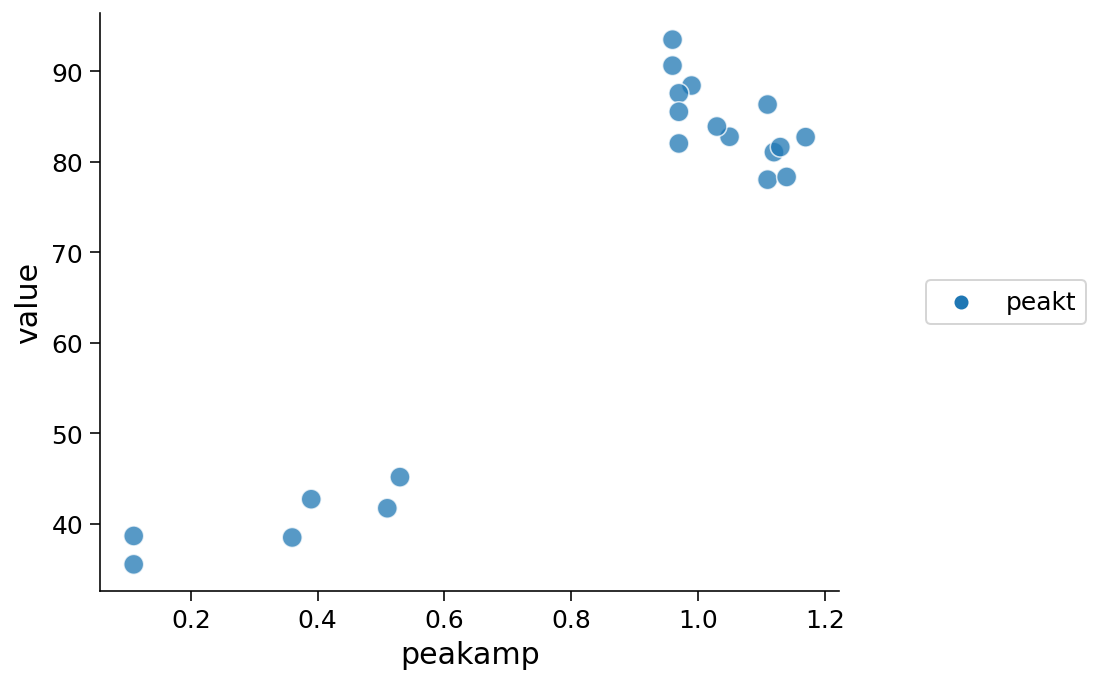

In [35]:
#@title {display-mode:"form"}

#@markdown Specify the filepath to a csv file
filepath = 'filepath to csv' #@param
filepath = '/Users/kperks/Documents/Teaching/Neurophysiology-Lab/modules/crayfish-erg/duration_.csv'

#@markdown Specify the single header name of the column you want for the x-axis data. 
x_column = ['column header for x axis'] #@param
x_column = ['peakamp']

# #@markdown Specify categorical bins using np.arange(start,stop,step) if the x_column is a continuous variable. 
# #@markdown Use empty brackets if not needed.
# categorical_bins = np.arange(0,25,0.5) #@param

#@markdown Specify the header name(s) of the column(s)s you want for your y points. 
#@markdown If more than one header is specified (separated by commas), each will be plotted overlaid in a different color for a scatter plot
y_column = ['column header(s) for y axis 1'] #@param
# y_column = ['steady state','peak']
# y_column = ['m1','m2']
y_column = ['peakt']

# #@markdown Specify the plot type ('scatter' or 'violin'). Note that for a 'violin' plot, only the 'x_column' data would be used.
# plot_type = 'plot type' #@param

# @markdown Specify the plot type ('scatter' or 'point'). 
# @markdown Note that for a 'point' plot, the x-axis is categorical and the y-axis data has error bars.
# plot_type = 'point'
plot_type = 'scatter' 

df = pd.read_csv(filepath)

hfig,ax = plt.subplots(figsize=(8,5))

if plot_type == 'scatter':
    df_melted = df[y_column+x_column].melt(x_column[0],var_name='headers')
    g = sns.scatterplot(data=df_melted,x=x_column[0],y='value',hue='headers',s=100,alpha=0.75, ax = ax);
    
            
if plot_type == 'point':
    df_melted = df[y_column+x_column].melt(x_column[0],var_name='headers')
    
#     if len(categorical_bins)>0:
#         df_melted[x_column[0]] = pd.cut(df_melted[x_column[0]],bins=categorical_bins,labels=categorical_bins[1:])
        
    g = sns.pointplot(data=df_melted,x=x_column[0],y='value',hue='headers',alpha=0.75);

        
g.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), ncol=1);
# ax.set_xlim(x_lim[0],x_lim[1])


<hr> 
Written by Dr. Krista Perks for courses taught at Wesleyan University.

<a id="setup"></a>

<a id="one"></a>

<a id="two"></a>

<a id="three"></a>

<a id="four"></a>